<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/MLP_AE/MLP_AE_Treasury10y.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 150 (delta 73), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (150/150), 121.14 KiB | 6.38 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Fri Jul 23 15:05:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Treasury10y'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'MLP_AE'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8 MB 7.6 MB/s 
     |████████████████████████████████| 170 kB 40.5 MB/s 
     |████████████████████████████████| 97 kB 2.0 MB/s 
     |████████████████████████████████| 133 kB 41.4 MB/s 
     |████████████████████████████████| 138 kB 46.4 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
     |████████████████████████████████| 62 kB 817 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop', 'sgd']
        },
        'activation': {
            'values': ['relu', 'selu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(Dense(256, activation=config.activation, input_shape=(window_len, 1)))
    # layer 2
    model.add(Dense(128, activation=config.activation))
    # layer 3
    model.add(Dense(64, activation=config.activation))
    # layer 4
    model.add(Dense(32, activation=config.activation))
    # layer 5
    model.add(Flatten())
    # layer 6
    model.add(RepeatVector(window_len))
    # layer 7
    model.add(Dense(32, activation=config.activation))
    # layer 8
    model.add(Dense(64, activation=config.activation))
    # layer 9
    model.add(Dense(128, activation=config.activation))
    # layer 10
    model.add(Flatten())
    # layer 11
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: due8fgzn
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_MLP_AE/sweeps/due8fgzn


In [16]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: vugrgd9f with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 5s 132ms/step - loss: 0.2566 - mean_squared_error: 0.2566 - mean_absolute_error: 0.3896 - val_loss: 0.2449 - val_mean_squared_error: 0.2449 - val_mean_absolute_error: 0.4727
Epoch 2/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0773 - mean_squared_error: 0.0773 - mean_absolute_error: 0.2322 - val_loss: 0.0537 - val_mean_squared_error: 0.0537 - val_mean_absolute_error: 0.1937
Epoch 3/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0391 - mean_squared_error: 0.0391 - mean_absolute_error: 0.1635 - val_loss: 0.0202 - val_mean_squared_error: 0.0202 - val_mean_absolute_error: 0.1182
Epoch 4/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0261 - mean_squared_error: 0.0261 - mean_absolute_error: 0.1277 - val_loss: 0.1783 - val_mean_squared_error: 0.1783 - val_mean_absolute_error: 0.3975
Epoch 5/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0489 - mean_squared_error: 0.

epoch,19
loss,0.00941
mean_squared_error,0.00941
mean_absolute_error,0.08465
val_loss,0.01204
val_mean_squared_error,0.01204
val_mean_absolute_error,0.09145
_runtime,12
_timestamp,1627054438
_step,19
best_val_loss,0.01033


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▃▂▁▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▁▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▇▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆███
_timestamp,▁▁▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆███
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: amjk8trg with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 5s 70ms/step - loss: 127.1115 - mean_squared_error: 127.1115 - mean_absolute_error: 8.9818 - val_loss: 11.9518 - val_mean_squared_error: 11.9518 - val_mean_absolute_error: 3.4555
Epoch 2/100
16/16 [==============================] - 0s 18ms/step - loss: 58.9203 - mean_squared_error: 58.9203 - mean_absolute_error: 6.2861 - val_loss: 23.6547 - val_mean_squared_error: 23.6547 - val_mean_absolute_error: 4.8451
Epoch 3/100
16/16 [==============================] - 0s 19ms/step - loss: 47.8985 - mean_squared_error: 47.8985 - mean_absolute_error: 5.5391 - val_loss: 34.9510 - val_mean_squared_error: 34.9510 - val_mean_absolute_error: 5.9061
Epoch 4/100
16/16 [==============================] - 0s 17ms/step - loss: 47.8099 - mean_squared_error: 47.8099 - mean_absolute_error: 5.5970 - val_loss: 65.0592 - val_mean_squared_error: 65.0592 - val_mean_absolute_error: 8.0554
Epoch 5/100
16/16 [==============================] - 0s 19ms/step - loss: 77.1

epoch,10
loss,31.00597
mean_squared_error,31.00597
mean_absolute_error,4.4228
val_loss,12.01566
val_mean_squared_error,12.01566
val_mean_absolute_error,3.2364
_runtime,11
_timestamp,1627054457
_step,10
best_val_loss,11.95182


epoch,▁▂▂▃▄▅▅▆▇▇█
loss,█▃▂▃▄▃▁▃▃▁▁
mean_squared_error,█▃▂▃▄▃▁▃▃▁▁
mean_absolute_error,█▄▂▃▄▃▂▃▂▁▁
val_loss,▁▁▂▃▇▁█▂▁▁▁
val_mean_squared_error,▁▁▂▃▇▁█▂▁▁▁
val_mean_absolute_error,▁▂▃▄█▂█▂▂▁▁
_runtime,▁▃▃▃▆▆▆████
_timestamp,▁▃▃▃▆▆▆████
_step,▁▂▂▃▄▅▅▆▇▇█


wandb: Agent Starting Run: 12fgl6qj with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 4s 38ms/step - loss: 2.6226 - mean_squared_error: 2.6226 - mean_absolute_error: 0.8345 - val_loss: 0.0718 - val_mean_squared_error: 0.0718 - val_mean_absolute_error: 0.2433
Epoch 2/100
32/32 [==============================] - 0s 14ms/step - loss: 0.1325 - mean_squared_error: 0.1325 - mean_absolute_error: 0.2794 - val_loss: 0.0161 - val_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.1008
Epoch 3/100
32/32 [==============================] - 0s 13ms/step - loss: 0.1278 - mean_squared_error: 0.1278 - mean_absolute_error: 0.1578 - val_loss: 0.0495 - val_mean_squared_error: 0.0495 - val_mean_absolute_error: 0.1890
Epoch 4/100
32/32 [==============================] - 0s 13ms/step - loss: 0.0223 - mean_squared_error: 0.0223 - mean_absolute_error: 0.1289 - val_loss: 0.0389 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1712
Epoch 5/100
32/32 [==============================] - 0s 13ms/step - loss: 0.2318 - mean_squared_

wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [17]:
# picking the best values
best_config = {
    'epochs': 100,
    'batch_size': 64,
    'learning_rate': 0.0005,
    'optimizer': 'adam',
    'activation': 'selu'
}

In [18]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(Dense(256, activation=best_config['activation'], input_shape=(window_len, 1)))
# layer 2
model.add(Dense(128, activation=best_config['activation']))
# layer 3
model.add(Dense(64, activation=best_config['activation']))
# layer 4
model.add(Dense(32, activation=best_config['activation']))
# layer 5
model.add(Flatten())
# layer 6
model.add(RepeatVector(window_len))
# layer 7
model.add(Dense(32, activation=best_config['activation']))
# layer 8
model.add(Dense(64, activation=best_config['activation']))
# layer 9
model.add(Dense(128, activation=best_config['activation']))
# layer 10
model.add(Flatten())
# layer 11
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  88769


In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30, 256)           512       
_________________________________________________________________
dense_1 (Dense)              (None, 30, 128)           32896     
_________________________________________________________________
dense_2 (Dense)              (None, 30, 64)            8256      
_________________________________________________________________
dense_3 (Dense)              (None, 30, 32)            2080      
_________________________________________________________________
flatten (Flatten)            (None, 960)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 960)           0         
_________________________________________________________________
dense_4 (Dense)              (None, 30, 32)            3

In [20]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/100
20/20 [==============================] - 2s 7ms/step - loss: 0.4550
Epoch 2/100
20/20 [==============================] - 0s 8ms/step - loss: 0.0044
Epoch 3/100
20/20 [==============================] - 0s 9ms/step - loss: 0.0020
Epoch 4/100
20/20 [==============================] - 0s 8ms/step - loss: 0.0014
Epoch 5/100
20/20 [==============================] - 0s 8ms/step - loss: 0.0013
Epoch 6/100
20/20 [==============================] - 0s 8ms/step - loss: 0.0014
Epoch 7/100
20/20 [==============================] - 0s 8ms/step - loss: 0.0011
Epoch 8/100
20/20 [==============================] - 0s 8ms/step - loss: 8.6411e-04
Epoch 9/100
20/20 [==============================] - 0s 9ms/step - loss: 9.5798e-04
Epoch 10/100
20/20 [==============================] - 0s 8ms/step - loss: 0.0015
Epoch 11/100
20/20 [==============================] - 0s 8ms/step - loss: 0.0012
Epoch 12/100
20/20 [==============================] - 0s 9ms/step - loss: 0.0023
Epoch 13/100
20/20 [=========

In [21]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

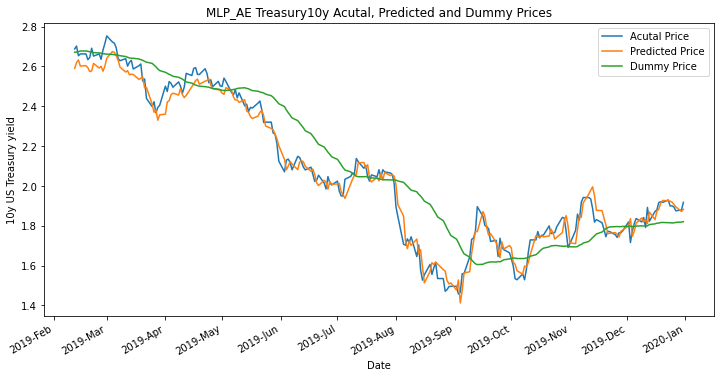

In [22]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

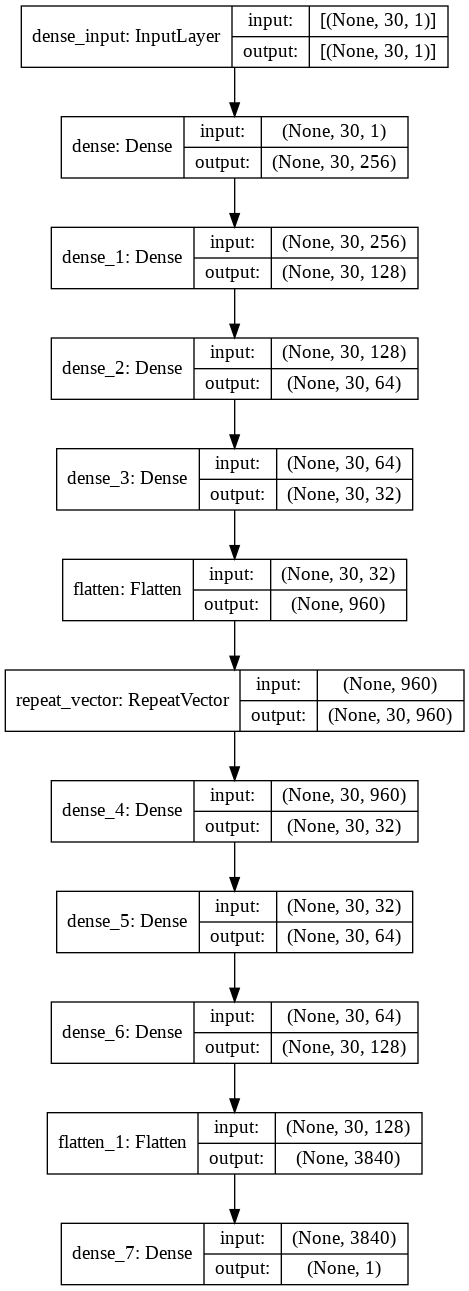

In [23]:
plot_model(model, show_shapes=True, expand_nested=True)

In [24]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.0021226679407225823
RMSE:  0.0460724206084571
MAE:  0.037024374049720955
Dummy MSE:  0.011907945328582062
Dummy RMSE:  0.10912353242349727
Dummy MAE:  0.08287353397503001


In [25]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/MLP_AE_Treasury10y/assets
